# Forward Euler Method: Numba Implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, float32
import numba
from scipy.sparse import coo_matrix

def heat_solver(N, plot_image = False):

    h = 2/(N-1)

    u0 = np.zeros((N, N), dtype=np.float64)
    u0_row1 = np.linspace(5, 5, N, dtype=np.float64)
    u0[0] = u0_row1

    dt = h**2/4 

    F = dt/h**2 #Mesh Fourier Number
    t = 0
    u = u0
    error = 1e-5

    counter = 0

    from numba import njit, jit
    @njit
    def next_step(u):
        u[0, 1:N-1] = u[0, 1:N-1] +  \
                  F*(u[0, 0:N-2] - 2*u[0, 1:N-1]+ u[0, 2:N])
        u[1:N-1, 1:N-1] = u[1:N-1, 1:N-1] +  \
                  F*(u[0:N-2, 1:N-1] - 2*u[1:N-1, 1:N-1]+ u[2:N, 1:N-1]) +\
                  F*(u[1:N-1, 0:N-2] - 2*u[1:N-1, 1:N-1]+ u[1:N-1, 2:N])
        u[N, 1:N-1] = u[N, 1:N-1] +  \
                  F*(u[N, 0:N-2] - 2*u[N, 1:N-1]+ u[N, 2:N])

        return u
    t_show = -0.00001
    while (u[N//2, N//2] - 1 < error and counter < 50000 ):

        #plot(u)
        if (plot_image):
            if ( t > t_show):
              print("Counter: " + str(counter) + " Time: " + str(t))
              plt.imshow(u)
              plt.show()
              t_show = t_show + 0.30

        u = next_step(u)


        t = t + dt
        counter = counter + 1
    
    if (plot_image):
        print("Counter: " + str(counter) + " Time: " + str(t))
        plt.imshow(u)
        plt.show()
    print("Temperature at (0, 0) is " + str(u[N//2, N//2]))
    return t

Counter: 0 Time: 0


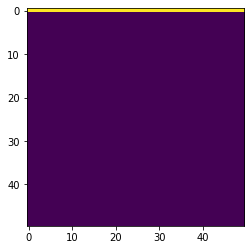

Counter: 721 Time: 0.300291545189502


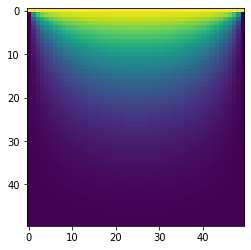

Counter: 1107 Time: 0.4610578925447761


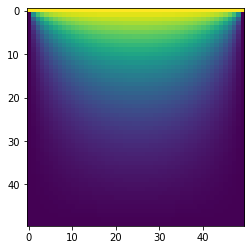

Temperature at (0, 0) is 1.0002246296577268
Total time taken: 0.4610578925447761


In [2]:
%timeit 
t = heat_solver(50, plot_image=True)
print ("Total time taken: " + str(t))

In [ ]:
 #benchmark
import time
import matplotlib.pyplot as plt
nArray = [10, 50, 100]
timeArray = []

for N in nArray:
    start = time.time()
    t = heat_solver(N)
    stop = time.time()
    interval = stop - start
    timeArray.append(interval) #measuring the time taken to run diffusion_iteration
    print ("Number of discrete points: " + str(N))
    

%matplotlib inline
plt.plot(nArray, timeArray, label = 'Time taken')

plt.xlabel('Array size N')
plt.ylabel('Runtime');
plt.legend()

Temperature at (0, 0) is 1.0002048010703686
Number of discrete points: 10


# Backward Euler Method: Sparse Matrix implementation

[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 1.002025  -0.0010125  0.        ...  0.         0.         0.       ]
 [-0.0010125  1.002025  -0.0010125 ...  0.         0.         0.       ]
 [ 0.        -0.0010125  1.002025  ...  0.         0.         0.       ]
 ...
 [ 0.         0.         0.        ...  1.002025  -0.0010125  0.       ]
 [ 0.         0.         0.        ... -0.0010125  1.002025  -0.0010125]
 [ 0.         0.         0.        ...  0.        -0.0010125  1.002025 ]]
Counter: 0 Time: 0 Temp: 0.0


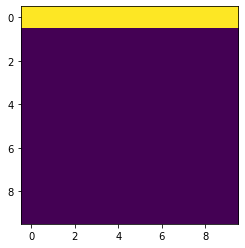

Counter: 1500 Time: 0.1499999999999998 Temp: 0.07767053299180354


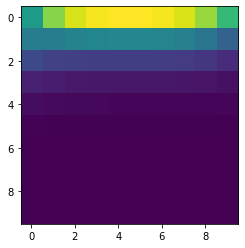

Counter: 3000 Time: 0.2999999999999833 Temp: 0.4277034042416568


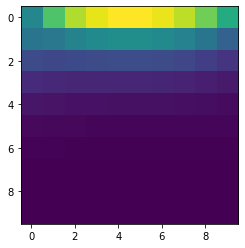

1.0004074529418157
0.4314999999999688


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, float32
import numba
from scipy.sparse import coo_matrix
import scipy
from scipy.sparse.linalg import spsolve

def heat_solver(N, dt = 1e-3):

    h = 2/(N-1)

    u0 = np.zeros((N, N), dtype=np.float64)
    u0_row1 = np.linspace(5, 5, N, dtype=np.float64)
    u0[0] = u0_row1
    print(u0)

    F = 0.5*dt/h**2 #Mesh Fourier Number
    t = 0
    u = u0
    error = 1e-5
    
    N2 = N*N
    counter = 0
    #Sparse matrix
    main      = np.zeros(N2)            # diagonal
    adjacent1 = np.zeros(N2-1)          # subdiagonal
    adjacent2 = np.zeros(N2-N)          # superdiagonal
    
    
    main[:] = 1 + 4*F
    adjacent1[:] = -F
    adjacent2[:] = -F
    main[0:N] = 1+ 2*F
    main [N2-N: N2] = 1+ 2*F
    
    A = scipy.sparse.diags(
                    diagonals=[main, adjacent1, adjacent2, adjacent1, adjacent2],
                    offsets=[0, -1, - N, 1, N], shape=(N*N, N*N),
                    format='csr')
    
    print (A.todense())  # Check that A is correct
    t_show = -0.000001
    counter = 0
    error = 1e-5
    u = np.reshape(u, -1)
    while (u[N*N//2] - 1 < error and counter < 1e6 and t < 0.5):
        #plot(u)
        if ( t > t_show):
            print("Counter: " + str(counter) + " Time: " + str(t) + " Temp: " + str(u[N*N//2]))
            u = np.reshape(u, (N,N))
            plt.imshow(u)
            plt.show()
            u = np.reshape(u, -1)
            t_show = t_show + 0.15
        b = u
        u[:] = spsolve(A, b)
        t = t + dt
        counter = counter + 1
    print(u[N*N//2])
    print(t)
    
    return u, t
    

u, t = heat_solver(10, 1e-4)

In [ ]:
 #benchmark
import time
import matplotlib.pyplot as plt
timeArray = [1e-5, 1e-4, 1e-3, 1e-2]
N = 10

for dt in timeArray:
    start = time.time()
    t = heat_solver(N, dt)
    stop = time.time()
    interval = stop - start
    timeArray.append(interval) #measuring the time taken to run diffusion_iteration
    print ("Number of discrete points: " + str(N))
    

%matplotlib inline
plt.plot(N, timeArray, label = 'Time taken')

plt.xlabel('Array size N')
plt.ylabel('Runtime');
plt.legend()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
1e-3

0.001